## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.tree import plot_tree

In [2]:
# load summary metrics file
summary_df = pd.read_csv('../data/derived/performance/summary.csv')

# preview dataframe
summary_df.sample(5)

,model_name,dataset_name,vector_name,hyperparameter_name,hyperparameter_value,metric_name,metric_value
657,decisiontree,dev,lsi100,maxdepth,10,binary_f1,0.702070
1620,decisiontree,train,lsi100,maxdepth,10,micro_f1,0.908419
628,decisiontree,dev,lsi100,maxdepth,100,binary_precision,0.654281
235,svc,dev,count,c,0.01,binary_recall,0.817708
867,mlp,dev,lsi5,alpha,10,binary_f1,0.000000


## Visualize decision tree

In [3]:
def get_vocab_list(vocabulary):
    """
    Convert count vectorizer vocabulary dictionary into ordered list
    """
    # initialize empty list of same length as vocabulary
    vocab_list = [None] * len(vocabulary)

    # iterate over items in count vectorizer's dictionary
    for token, index in vocabulary.items():
        # save token at corresponding index in vocabulary list
        vocab_list[index] = token
        
    return vocab_list

In [4]:
def plot_decision_tree():
    """
    Plot first two branches of smallest decision tree with count vectors for interpretability
    """
    # import decision tree model
    tree = pickle.load(open('../data/derived/models/decisiontree_vectorcount_maxdepth10.pkl', 'rb' ))

    # import bag of words transformer
    count_vectorizer = pickle.load(open('../data/derived/models/vectorizer_count.pkl', 'rb'))

    # get vocabulary as ordered list
    vocab_list = get_vocab_list(count_vectorizer.vocabulary_)
    
    # plot decision tree
    plt.figure(figsize=(15,9))
    plot_tree(tree, fontsize=12, max_depth=2, feature_names=vocab_list, rounded=True, 
              class_names=['not sexist', 'sexist'])
    
    # save and show figure
    plt.savefig('../data/derived/visualizations/decisiontree_branches.png', format='png')
    plt.show()
    
    return None

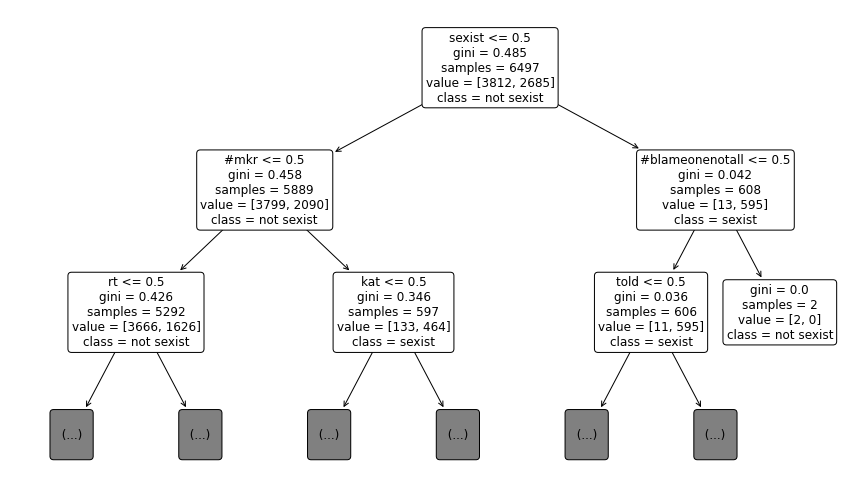

In [5]:
plot_decision_tree()

## Visualize performance with line plots

In [6]:
def visualize_model_metric(summary_df, metric_name, model_name):
    """
    Print line graph of training and development performance for provided metric and model
    """
    
    # copy summary dataframe
    df = summary_df.copy()
    
    # filter dataframe to provided metric
    df = df[df['metric_name'] == metric_name]
    
    # get y-limit to use regardless of model type
    y_lim = (min(df['metric_value']), max(df['metric_value'])+0.01)
    
    # filter dataframe to provided model
    df = df[df['model_name']  == model_name]
    
    # reset indices
    df.reset_index(inplace=True, drop=True)
        
    # get hyperparameter name (assumes only one hyperparameter name per model)
    hyperparameter_name = df['hyperparameter_name'].unique()[0]
    
    # sort dataframe by vector name
    df.sort_values(by='vector_name', inplace=True)
    
    # sort dataframe by ascending hyperparameter value
    sorted_idx = np.argsort([float(x) if x.replace('.','',1).isnumeric() else float('inf') for x in df['hyperparameter_value']])
    df = df.iloc[sorted_idx, :]
    
    # set plot style
    sns.set_style("whitegrid")
    
    # plot decision tree performance
    g = sns.relplot(data = df,
                    x = 'hyperparameter_value',
                    y = 'metric_value',
                    hue = 'dataset_name', 
                    row = 'vector_name',
                    row_order = ['count','tfidf','lsi5','lsi10','lsi50','lsi100'],
                    kind = 'line',
                    height = 2.25,
                    aspect = 2)
    
    # adjust y-axis limit
    g.set(ylim=y_lim)
    
    # write figure to visualizations file
    g.savefig(f'../data/derived/visualizations/{model_name}_{metric_name}.png')
    
    return None

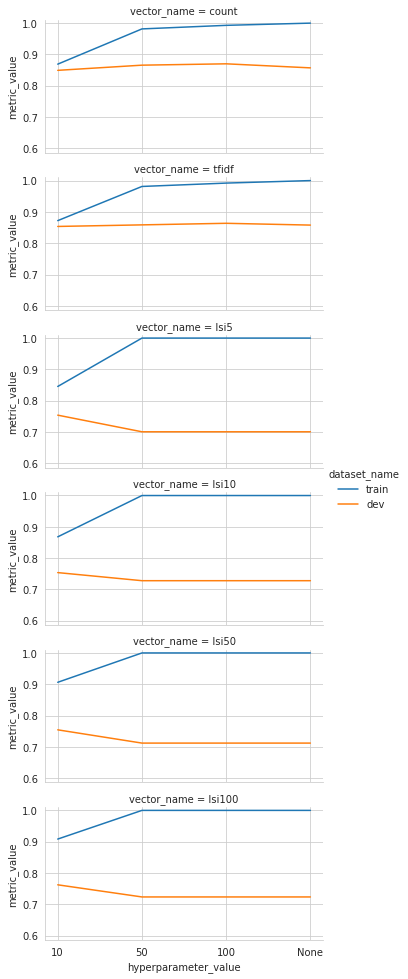

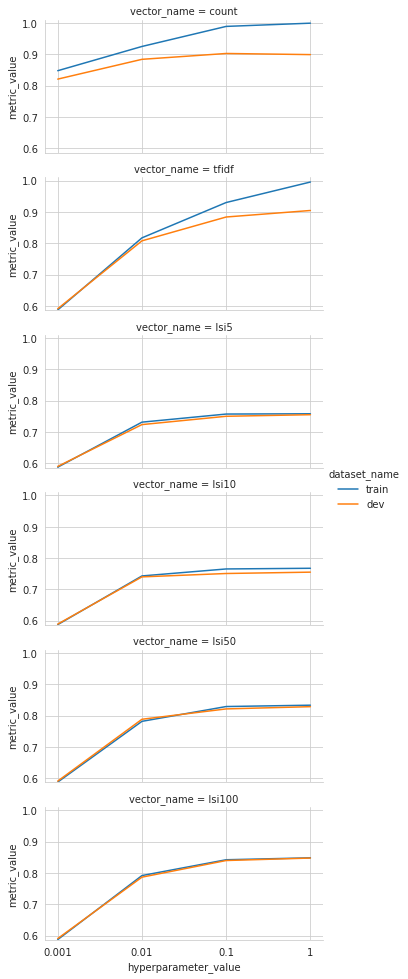

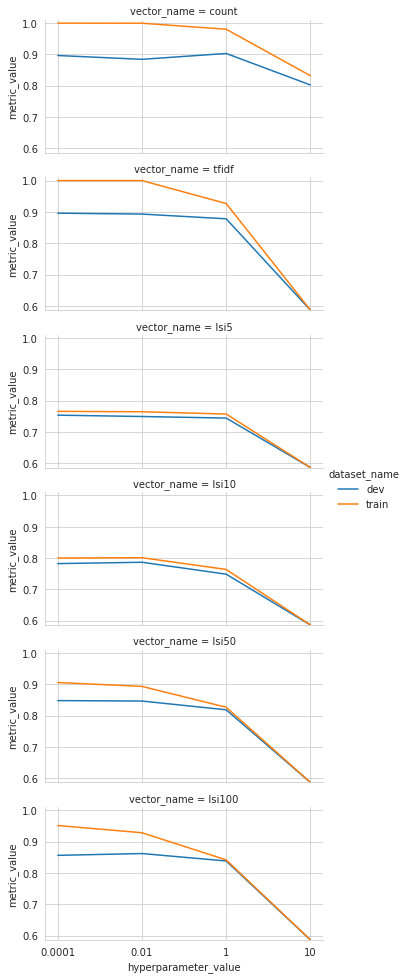

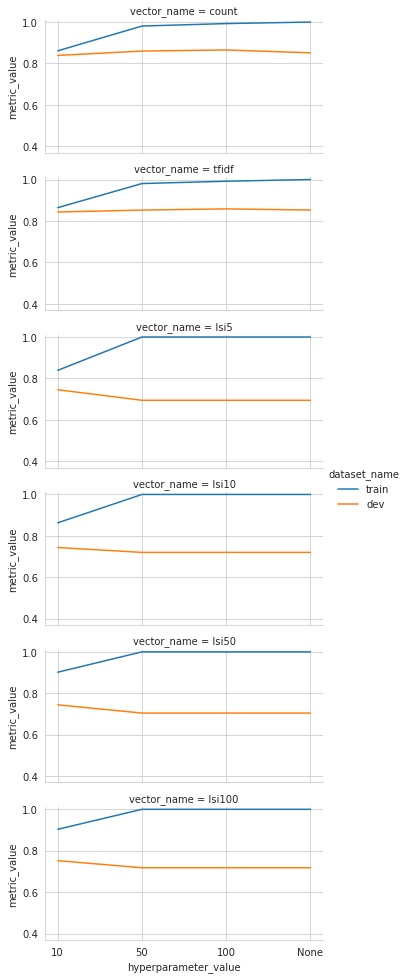

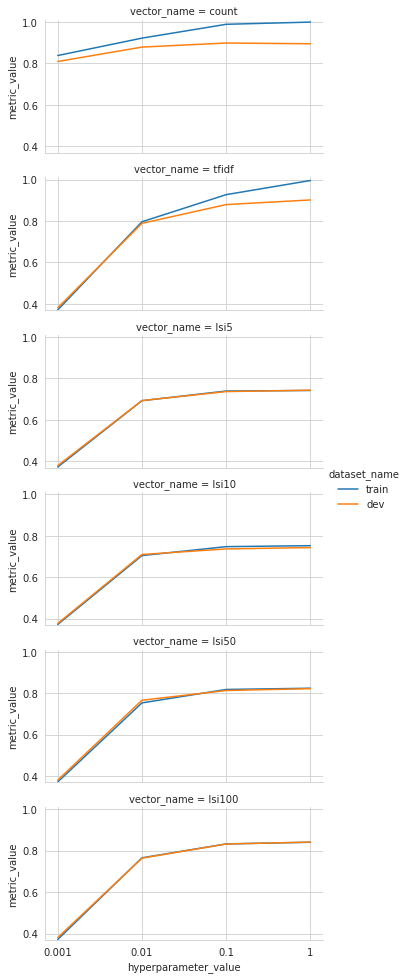

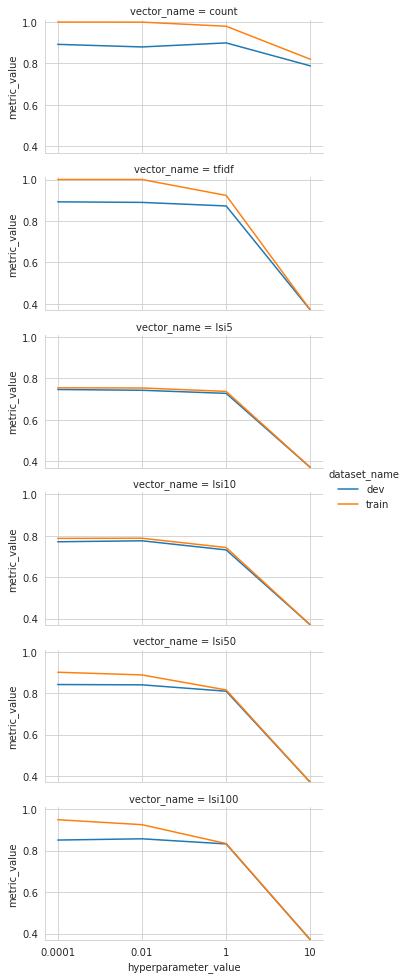

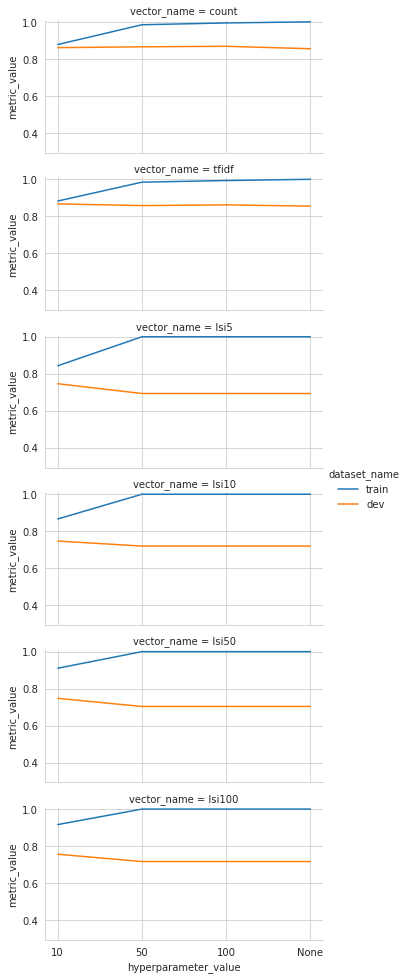

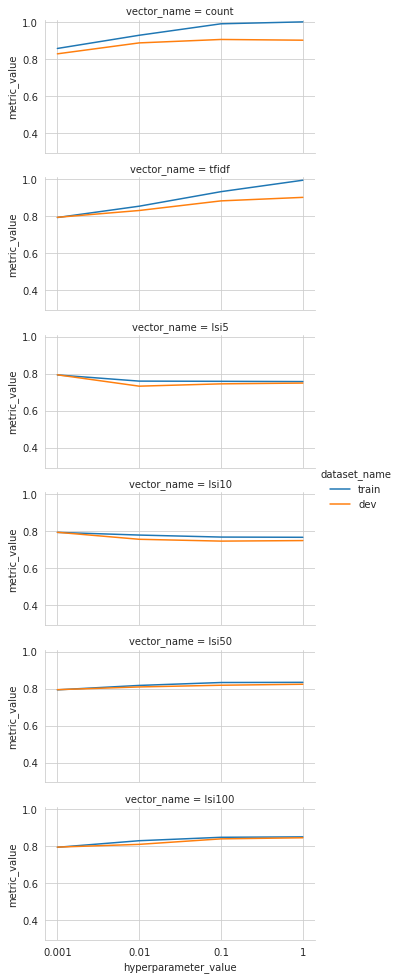

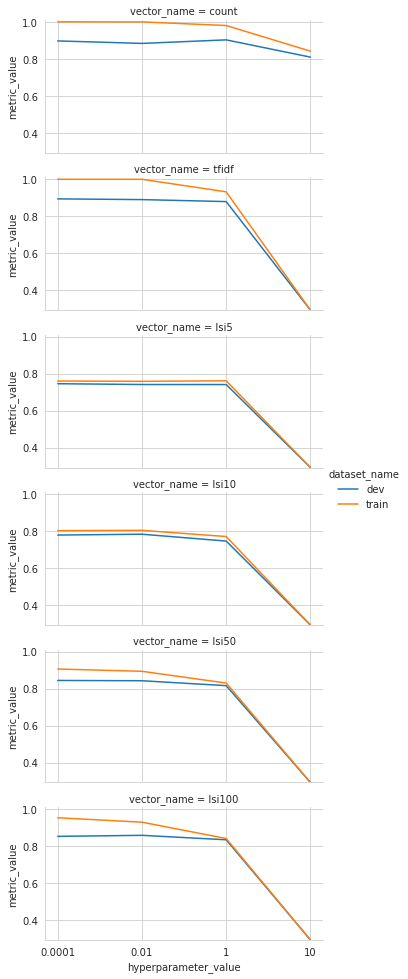

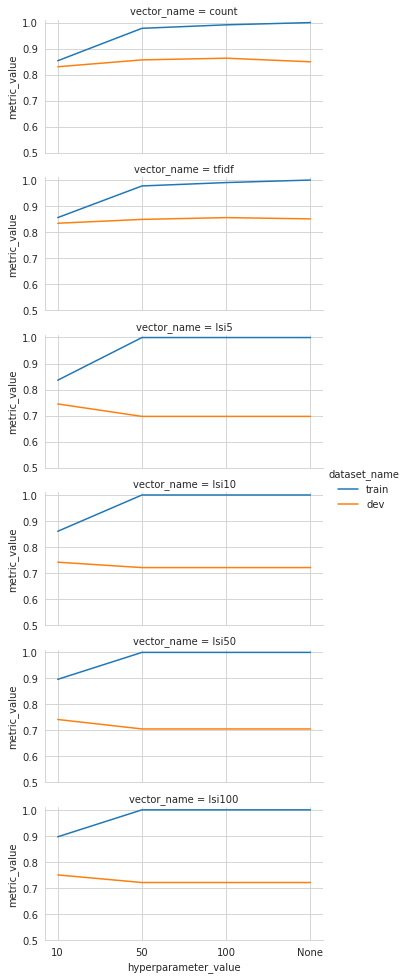

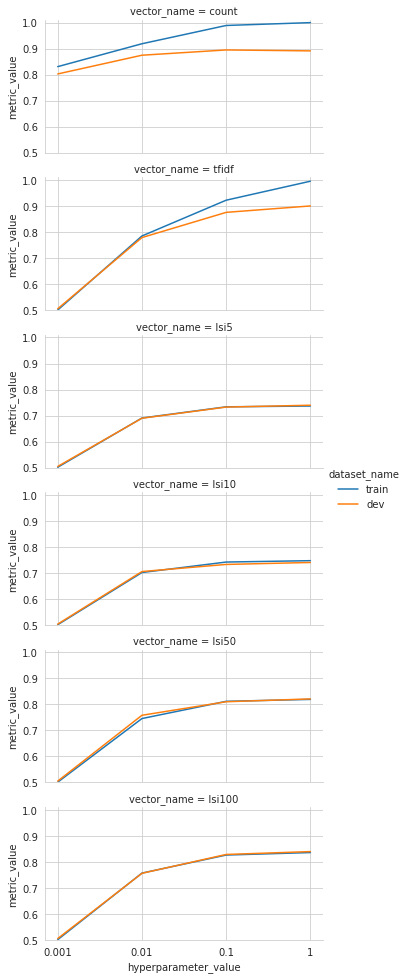

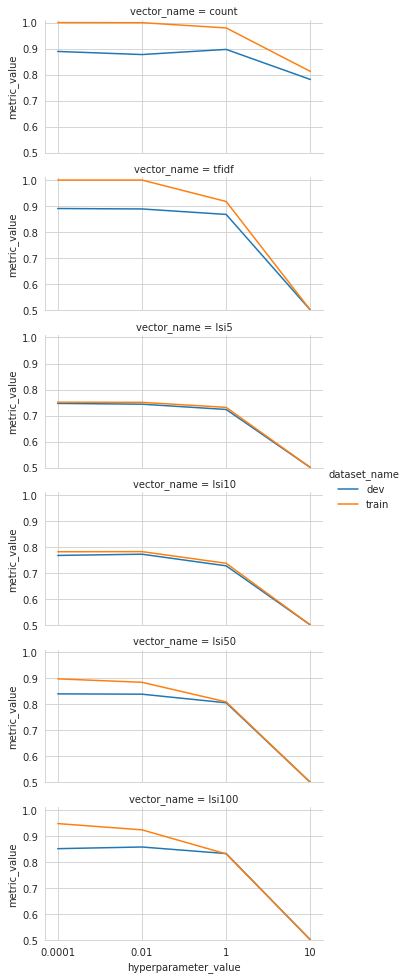

In [7]:
# initialize lists of metrics and models of interest
metric_name_list = ['accuracy', 'macro_f1', 'macro_precision', 'macro_recall']
model_name_list  = ['decisiontree', 'svc', 'mlp']

# iterate over metrics
for metric_name in metric_name_list:
    # iterate over models
    for model_name in model_name_list:
        # create and save visualization
        visualize_model_metric(summary_df, metric_name, model_name)